# MODIS Fit

In [40]:
# imports
from importlib import reload
import numpy as np

from scipy.interpolate import interp1d

from oceancolor.hydrolight import loisel23

from big.models import anw as big_anw
from big.models import bbnw as big_bbnw
from big import inference as big_inf
from big import rt as big_rt
from big import chisq_fit
from big import plotting

In [2]:
%matplotlib ipympl

# Load L23

In [4]:
ds = loisel23.load_ds(4,0)

## Choose our spectrum to analyze

In [37]:
idx = 170 # Random choice

## Unpack for convenience

In [38]:
l23_wave = ds.Lambda.data
l23_a = ds.a.data[idx]
l23_aph = ds.aph.data[idx]
l23_anw = ds.anw.data[idx] 
l23_bb = ds.bb.data[idx] 
l23_bbnw = ds.bbnw.data[idx] 
l23_Rrs = ds.Rrs.data[idx]

# Calculate Perfect RT

In [22]:
# Gordon Rrs
gordon_Rrs = big_rt.calc_Rrs(l23_a, l23_bb)

# MODIS Bands

In [15]:
modis_wave = [412, 443, 469, 488, 531, 547, 555, 645, 667, 678, 748]# , 859, 869] # nm
modis_wave = np.array(modis_wave)

# Interpolate

In [27]:
l23_i_Rrs = interp1d(l23_wave, gordon_Rrs)
l23_i_a = interp1d(l23_wave, l23_a)
l23_i_bb = interp1d(l23_wave, l23_bb)

In [29]:
modis_Rrs = l23_i_Rrs(modis_wave)
modis_a = l23_i_a(modis_wave)
modis_bb = l23_i_bb(modis_wave)

# Prep our models

In [24]:
model_names = ['Exp', 'Pow']

# Init the models
anw_model = big_anw.init_model(model_names[0], modis_wave, 'log')
bbnw_model = big_bbnw.init_model(model_names[1], modis_wave, 'log')
models = [anw_model, bbnw_model]

## Bricaud?

In [25]:
if models[0].name == 'ExpBricaud':
    models[0].set_aph(odict['Chl'])    

## Initial guess

In [30]:
p0_a = anw_model.init_guess(modis_a)
p0_b = bbnw_model.init_guess(modis_bb)
p0 = np.concatenate((np.log10(np.atleast_1d(p0_a)), 
                     np.log10(np.atleast_1d(p0_b))))

# Errors

In [32]:
scl_noise = 0.02
varRrs = (scl_noise*modis_Rrs)**2

# Fit 

In [33]:
items = [(modis_Rrs, varRrs, p0, idx)]

## Chisq

In [36]:
ans, cov, idx = chisq_fit.fit(items[0], models)

### Plot

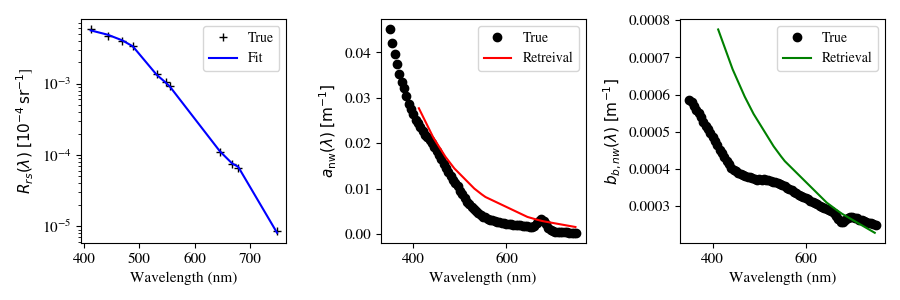

In [62]:
reload(plotting)
_ = plotting.show_fit(models, ans, figsize=(9,3), fontsize=11.,
                     anw_true=dict(wave=l23_wave, spec=l23_anw),
                     bbnw_true=dict(wave=l23_wave, spec=l23_bbnw),
                     Rrs_true=dict(wave=modis_wave, spec=modis_Rrs),)
                     #Rrs_true=dict(wave=l23_wave, spec=gordon_Rrs),)

## Bayesian

In [ ]:
chains, idx = big_inf.fit_one(items[0], models=models, pdict=pdict, chains_only=True)